##  <span style='background :#96e773' > 1. Introduction </span>

Ce notebook regroupe les dernières étapes de preprocessing effectuées sur le jeu de données final :
- imputation des valeurs manquantes
- feature engineering
- features selection

In [24]:
# Importation des librairies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sys
import sklearn
import gc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Versions
print('Version des librairies utilisées:')
print('Python ' + sys.version)
print('Pandas ' + pd.__version__)
print('NumPy ' + np.__version__)
print('Seaborn ' + sns.__version__)
print('Matplotlib ' + matplotlib.__version__)
print('Sklearn ' + sklearn.__version__)

Version des librairies utilisées:
Python 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
Pandas 1.5.2
NumPy 1.23.5
Seaborn 0.12.2
Matplotlib 3.5.3
Sklearn 1.2.2


In [25]:
from matplotlib import rcParams

# Définition des tailles de polices des figures


SMALL_SIZE = 15
MEDIUM_SIZE = 16
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)

rcParams['axes.titlepad'] = 20
plt.rcParams['figure.dpi'] = 100

sns.set(style="darkgrid")

**Fonctions**

In [26]:
def dim(df):
    x, y = df.shape
    print(f'Le jeu de données contient {x} lignes et {y} colonnes.')

In [27]:
def missing_values(df):
    a = df.isna().sum().sum()
    b = round(df.isna().mean().mean() * 100, 3)
    print(f'Le jeu de données contient {a} valeurs manquantes ({b}%).')

In [28]:
def recap_missing_values(df):
    df = pd.DataFrame(df)
    a = df.notna().sum()
    b = df.isna().sum()
    c = round((1 - df.isna().mean()) * 100, 3)
    d = pd.concat([a, b, c], axis=1).reset_index()
    d.columns = ['Variable',
                 'Nombre de valeurs renseignées',
                 'Nombre de valeurs manquantes',
                 'Taux de remplissage (%)']
    return d

In [29]:
def percentile_report(df, columns):
    quantiles = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]
    results = []
    for col in columns:
        col_results = []
        for q in quantiles:
            value = df[col].quantile(q)
            col_results.append(value)
        results.append(col_results)
    results_df = pd.DataFrame(results, columns=[f'{q*100}%' for q in quantiles], index=columns)
    return results_df

In [30]:
def compute_mode_percentage(df, columns, threshold, pr=True):
    data = []
    for col in columns:
        mode = df[col].mode().values[0]
        mode_perc = df[col].value_counts(normalize=True)[mode]

        data.append({'Column': col, 'Mode': mode, 'Mode_pct': mode_perc})

    result_df = pd.DataFrame(data)
    col = result_df.loc[result_df['Mode_pct'] >= threshold, 'Column'].tolist()

    if pr:
        print(result_df.sort_values(by='Mode_pct'))
        print('')

    print('Liste des features à supprimer :')
    print(col)
    return col

<br>

---

##  <span style='background :#96e773' > 2. Chargements des jeux de données </span>

On charge les jeux de données.

In [31]:
train = pd.read_csv("train_after_merging.csv")
test = pd.read_csv("test_after_merging.csv")

In [32]:
dim(train)

Le jeu de données contient 307504 lignes et 774 colonnes.


In [33]:
dim(test)

Le jeu de données contient 48744 lignes et 773 colonnes.


<br>

---

##  <span style='background :#96e773' > 3. Création d'un validation set </span>

On sépare le jeu d'entrainement en un jeu d'entrainement et un jeu de validation. On utilise l'hyperparamètre "stratify" afin de respecter la distribution de la target.

In [34]:
from sklearn.model_selection import train_test_split

# Define the features and the target variable
X = train.drop('TARGET', axis=1)
y = train['TARGET']

# Split the train dataset into a training set and a validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
X_train.shape

(246003, 773)

In [36]:
X_validation.shape

(61501, 773)

<br>

---

##  <span style='background :#96e773' > 4. Missing values imputation </span>

Nous avons vu dans le notebook d'analyse exploratoire l'importance des variables "EXT_SOURCE" (fort pouvoir informatif). Nous allons donc utiliser l'algorithme XGBOOST afin d'imputer les valeurs manquantes de ces variables.

Pour le reste des variables, nous utiliserons l'imputation par la médiane.


### <span style='background :#e3e33d' > 4.1 EXT_SOURCE </span>
#### <span style='background :#cdcdfc' > Sélection des variables pour l'imputation </span>

In [37]:
X_train_xgb = X_train.copy()
X_validation_xgb = X_validation.copy()
test_xgb = test.copy()

In [38]:
recap_missing_values(X_train_xgb[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']])

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,EXT_SOURCE_1,107273,138730,43.606
1,EXT_SOURCE_2,245476,527,99.786
2,EXT_SOURCE_3,197281,48722,80.195


Nous utiliserons uniquement les variables présentes dans les jeux de données principaux "application" pour l'imputation. On n'utilisera pas les variables issues du feature engineering avec les variables "EXT_SOURCE".

In [39]:
X_train_xgb.columns.get_loc('AGE_RANGE')

56

In [40]:
# Liste des variables à utiliser

col = X_train_xgb.iloc[:, 1:57].columns.tolist()
col

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CNT_DOC',
 'PERC_INC_CRED',
 'PERC_INC_ANN',
 'AMT_MONTHS',
 'PERC_INSURANCE_CRED',
 'INCOME_PER_MEMBER',
 'IN

Parmi ces variables, on élimine les variables dont le mode représente 90 % ou plus des valeurs.

In [41]:
col_to_del = compute_mode_percentage(X_train_xgb, col, 0.90, pr=False)

Liste des features à supprimer :
['NAME_CONTRACT_TYPE', 'FLAG_EMAIL', 'REG_CITY_NOT_LIVE_CITY', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8']


On peut maintenant dresser la liste finale des variables qui seront utiliser pour l'imputation avec XGBOOST.

In [42]:
col = sorted(list(set(col) - set(col_to_del)))
columns_for_modelling = sorted(list(set(col) - {'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'}))
len(columns_for_modelling)

47

#### <span style='background :#cdcdfc' > Imputation avec XGBOOST </span>

On impute en premier la variable "EXT_SOURCE_2" qui a le taux de remplissage (TDR) le plus élevé et on termine l'imputation avec "EXT_SOURCE_1" qui a le TDR le plus faible.
Chaque variable imputée est utilisée pour l'imputation de la variable suivante.

Pour éviter toute fuite de données, le modèle XGBOOST n'est entrainé que sur le jeu d'entrainement.

In [43]:
from xgboost import XGBRegressor
import time

start_time = time.time()

for ext_col in ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1']:
    X_model = X_train_xgb.loc[X_train_xgb[ext_col].notna(), columns_for_modelling]
    y_model = X_train_xgb.loc[X_train_xgb[ext_col].notna(), ext_col]

    X_train_xgb_missing = X_train_xgb.loc[X_train_xgb[ext_col].isna(), columns_for_modelling]
    X_validation_xgb_missing = X_validation_xgb.loc[X_validation_xgb[ext_col].isna(), columns_for_modelling]
    test_xgb_missing = test_xgb.loc[test_xgb[ext_col].isna(), columns_for_modelling]

    xg = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=59)
    xg.fit(X_model, y_model)

    X_train_xgb.loc[X_train_xgb[ext_col].isna(), ext_col] = xg.predict(X_train_xgb_missing)
    X_validation_xgb.loc[X_validation_xgb[ext_col].isna(), ext_col] = xg.predict(X_validation_xgb_missing)
    test_xgb.loc[test_xgb[ext_col].isna(), ext_col] = xg.predict(test_xgb_missing)

    #adding the predicted column to columns for modelling for next column's prediction
    columns_for_modelling = columns_for_modelling + [ext_col]

end_time = time.time()
time_taken = end_time - start_time

print(f"Imputation process took {time_taken:.2f} seconds")

Imputation process took 150.56 seconds


Nous allons maintenant comparer les distributions avant et après imputation.

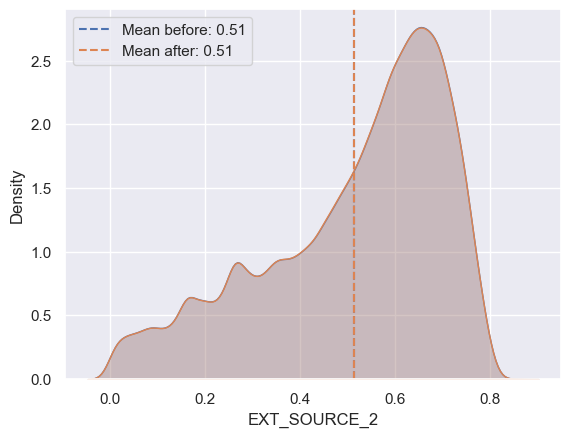

In [44]:
sns.kdeplot(data=X_train, x='EXT_SOURCE_2', fill=True)
sns.kdeplot(data=X_train_xgb, x='EXT_SOURCE_2', fill=True)

mean_0 = X_train['EXT_SOURCE_2'].mean()
mean_1 = X_train_xgb['EXT_SOURCE_2'].mean()

plt.axvline(mean_0, color=sns.color_palette()[0], linestyle='dashed', label=f'Mean before: {mean_0:.2f}')
plt.axvline(mean_1, color=sns.color_palette()[1], linestyle='dashed', label=f'Mean after: {mean_1:.2f}')

# # Add legend and show plot
plt.legend(loc='upper left')
plt.show()

"EXT_SOURCE_2" étant la variable avec le TDR le plus élevé (99.8 %), on n'observe aucune différence entre les deux distributions.

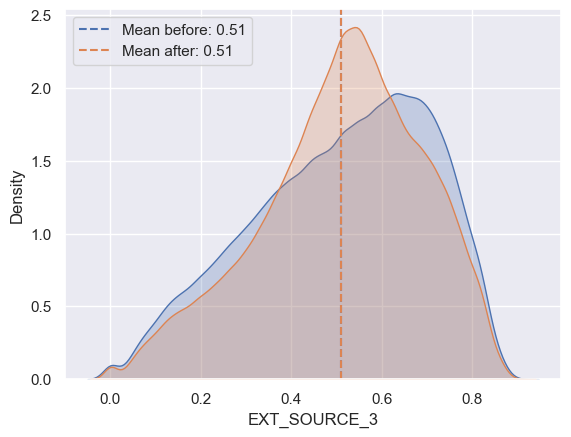

In [45]:
sns.kdeplot(data=X_train, x='EXT_SOURCE_3', fill=True)
sns.kdeplot(data=X_train_xgb, x='EXT_SOURCE_3', fill=True)

mean_0 = X_train['EXT_SOURCE_3'].mean()
mean_1 = X_train_xgb['EXT_SOURCE_3'].mean()

plt.axvline(mean_0, color=sns.color_palette()[0], linestyle='dashed', label=f'Mean before: {mean_0:.2f}')
plt.axvline(mean_1, color=sns.color_palette()[1], linestyle='dashed', label=f'Mean after: {mean_1:.2f}')

# # Add legend and show plot
plt.legend(loc='upper left')
plt.show()

Pour "EXT_SOURCE_3" (TDR de 80 %), on observe un décalage du mode vers les plus faibles valeurs (0.6 à 0.5) mais aucune différence entre les moyennes.

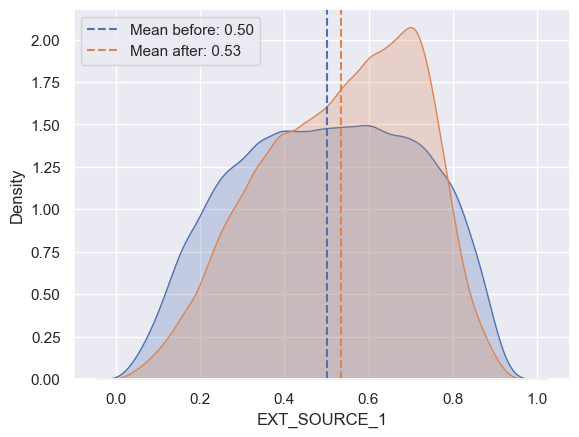

In [46]:
sns.kdeplot(data=X_train, x='EXT_SOURCE_1', fill=True)
sns.kdeplot(data=X_train_xgb, x='EXT_SOURCE_1', fill=True)

mean_0 = X_train['EXT_SOURCE_1'].mean()
mean_1 = X_train_xgb['EXT_SOURCE_1'].mean()

plt.axvline(mean_0, color=sns.color_palette()[0], linestyle='dashed', label=f'Mean before: {mean_0:.2f}')
plt.axvline(mean_1, color=sns.color_palette()[1], linestyle='dashed', label=f'Mean after: {mean_1:.2f}')

# # Add legend and show plot
plt.legend(loc='upper left')
plt.show()

"EXT_SOURCE_1" étant la variable avec le TDR le plus faible (44 %), on observe la modification la plus prononcée de la distribution avec un shift de la moyenne de 0.5 à 0.53.
Les scores "EXT_SOURCE_1" des clients imputés se situent entre 0.5 et 0.8.

In [47]:
percentile_report(X_train_xgb[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
EXT_SOURCE_1,1.456813e-02,0.116274,0.213179,0.273319,0.394498,0.553582,0.684173,0.760805,0.799421,0.866917,0.962693
EXT_SOURCE_2,8.173617e-08,0.029391,0.132879,0.215715,0.392752,0.565913,0.663497,0.721959,0.747631,0.782700,0.855000
EXT_SOURCE_3,5.272652e-04,0.072983,0.174564,0.256706,0.397946,0.524852,0.639708,0.735221,0.776410,0.832785,0.896010


On n'observe pas de différence majeure sur les centiles. Les minimums et maximums de chaque variable avant et après imputation sont identiques.

<br>

---

### <span style='background :#e3e33d' > 4.2 Reste des features </span>
#### <span style='background :#cdcdfc' > SimpleImputer médiane </span>

Encore une fois, on fit le modèle que sur le jeu d'entrainement pour éviter toute fuite de données.

In [48]:
from sklearndf.transformation import SimpleImputerDF

# Initialize median imputer
imputer = SimpleImputerDF(strategy='median')

# Fit the imputer on the train set
imputer.fit(X_train_xgb)

# Transform train, validation, and test sets
X_train_xgb_med = imputer.transform(X_train_xgb)
X_validation_xgb_med = imputer.transform(X_validation_xgb)
test_xgb_med = imputer.transform(test_xgb)

<br>

---

### <span style='background :#e3e33d' > 4.3 Update du feature engineering sur application_train </span>

On met à jour les variables issues du feature engineering suite à l'imputation des valeurs manquantes.

In [49]:
def feature_engineering_update(df):

    df['PERC_INC_CRED'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['PERC_INC_ANN'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
    df['AMT_MONTHS'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['PERC_INSURANCE_CRED'] = (df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']) / df['AMT_CREDIT']
    df['INCOME_PER_MEMBER'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['INCOME_PER_CHILD'] = df['AMT_INCOME_TOTAL'] / (df['CNT_CHILDREN'] + 1)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / (df['DAYS_BIRTH'] / -365)
    df['INCOME_TO_BIRTH_RATIO'] = - df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['AGE_END'] = df['AMT_MONTHS'] / 12 + (df['DAYS_BIRTH'] / -365)
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / (df['DAYS_EMPLOYED'] / -365)
    df['INCOME_TO_EMPLOYED_RATIO'] = - df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCE_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCE_1_TO_BIRTH_RATIO'] = df['EXT_SOURCE_1'] / (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_1_TO_EMPLOY_RATIO'] = df['EXT_SOURCE_1'] / (df['DAYS_EMPLOYED'] / -365)
    df['EXT_SOURCE_1_DAYS_BIRTH'] = df['EXT_SOURCE_1'] * (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_1_DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * (df['DAYS_EMPLOYED'] / -365)
    df['EXT_SOURCE_2_TO_BIRTH_RATIO'] = df['EXT_SOURCE_2'] / (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_2_TO_EMPLOY_RATIO'] = df['EXT_SOURCE_2'] / (df['DAYS_EMPLOYED'] / -365)
    df['EXT_SOURCE_2_DAYS_BIRTH'] = df['EXT_SOURCE_2'] * (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_2_DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * (df['DAYS_EMPLOYED'] / -365)
    df['EXT_SOURCE_2_TO_REGION_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT']
    df['EXT_SOURCE_2_REGION_RATING_CLIENT'] = df['EXT_SOURCE_2'] * df['REGION_RATING_CLIENT']
    df['EXT_SOURCE_3_TO_BIRTH_RATIO'] = df['EXT_SOURCE_3'] / (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_3_DAYS_BIRTH'] = df['EXT_SOURCE_3'] * (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_1_TO_EXT_SOURCE_2_RATIO'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_2']
    df['EXT_SOURCE_2_TO_EXT_SOURCE_3_RATIO'] = df['EXT_SOURCE_2'] / df['EXT_SOURCE_3']
    df['EXT_SOURCE_1_TO_EXT_SOURCE_3_RATIO'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_3']
    df['EXT_SOURCE_1_EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['EXT_SOURCE_2_EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCE_1_EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']

    return df

Cette mise à jour est effectuée sur le jeu d'entrainement, de validation et de test.

In [50]:
X_train_xgb_med = feature_engineering_update(X_train_xgb_med)
X_validation_xgb_med = feature_engineering_update(X_validation_xgb_med)
test_xgb_med = feature_engineering_update(test_xgb_med)

<br>

---

##  <span style='background :#96e773' > 5. Création d'une nouvelle variable </span>

On crée une nouvelle variable "TARGET_NEIGHBORS_500_MEAN" qui est la moyenne de la target des 500 clients les plus proches.
On utilise un modèle KNN entrainé sur les variables 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3' et 'AMT_MONTHS'.
Pour éviter toute fuite de données, ce modèle est entrainé uniquement sur le jeu d'entrainement.

In [51]:
from sklearn.neighbors import KNeighborsClassifier

train_data_for_neighbors = X_train_xgb_med[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_MONTHS']]
validation_data_for_neighbors = X_validation_xgb_med[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_MONTHS']]
test_data_for_neighbors = test_xgb_med[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_MONTHS']]

In [52]:
knn = KNeighborsClassifier(500, n_jobs=-1)
knn.fit(train_data_for_neighbors, y_train)

train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
validation_500_neighbors = knn.kneighbors(validation_data_for_neighbors)[1]
test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

In [53]:
#adding the means of targets of 500 neighbors to new column
X_train_xgb_med['TARGET_NEIGHBORS_500_MEAN'] = [y_train.iloc[ele].mean() for ele in train_500_neighbors]
X_validation_xgb_med['TARGET_NEIGHBORS_500_MEAN'] = [y_train.iloc[ele].mean() for ele in validation_500_neighbors]
test_xgb_med['TARGET_NEIGHBORS_500_MEAN'] = [y_train.iloc[ele].mean() for ele in test_500_neighbors]

In [54]:
del train_500_neighbors, validation_500_neighbors, test_500_neighbors
gc.collect()

151257

<br>

---

##  <span style='background :#96e773' > 6. Feature selection </span>

Le jeu de données contenant un nombre élevé de variables (773), nous allons maintenant effectuer une sélection des features afin d'améliorer la qualité, la performance et l'interprétabilité de notre futur modèle de machine learning.

Nous utiliserons trois techniques :

1) Suppression des features corrélées (seuil à 0.9)
2) Sélection des features avec LightGBM (feature importance)
3) Sélection des features avec BorutaPy

Pour éviter le surapprentissage et prévenir toute fuite de données, nous utiliserons ces techniques sur le jeu d'entrainement uniquement.
Nous utiliserons le jeu de validation pour estimer l'impact de la réduction du nombre de variables sur les performances de classification.

In [55]:
client_id = X_train_xgb_med['SK_ID_CURR']
client_id_val = X_validation_xgb_med['SK_ID_CURR']

In [56]:
client_id.to_csv('client_id.csv', index=False)
client_id_val.to_csv('client_id_val.csv', index=False)

In [57]:
X_train_xgb_med.drop(columns='SK_ID_CURR', inplace=True)
X_validation_xgb_med.drop(columns='SK_ID_CURR', inplace=True)

### <span style='background :#e3e33d' > 6.1 Features corrélées </span>

In [58]:
def remove_highly_correlated_features(X, threshold=0.9):
    # Calculate the correlation matrix
    corr_matrix = X.corr().abs()

    # Find the upper triangular matrix without the diagonal elements
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify the columns to remove based on the correlation threshold
    cols_to_remove = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    return cols_to_remove

In [59]:
columns_without_source = [col for col in X_train_xgb_med.columns if 'SOURCE' not in col]

In [60]:
list_corr = remove_highly_correlated_features(X_train_xgb_med[columns_without_source], threshold=0.9)

In [61]:
len(list_corr)

184

184

<br>

---

### <span style='background :#e3e33d' > 6.2 LightGBM feature importance </span>


On crée une fonction qui calcule et liste les variables avec une feature importance nulle.

In [62]:
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold

def lightgbm_feature_importance(train_df, y_train_df, threshold=0):

    start_time = time.time()

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train_df.shape[1])

    scale_pos_weight_value = sum(y_train_df == 0) / sum(y_train_df == 1)

    # Create a LightGBM classifier with scale_pos_weight
    model = lgb.LGBMClassifier(objective='binary', boosting_type='goss', n_estimators=10000, scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1)

    # Define the early stopping and log evaluation callbacks
    early_stopping_callback = early_stopping(stopping_rounds=100, first_metric_only=True)
    log_evaluation_callback = log_evaluation(period=200)

    # Prepare the KFold cross-validation
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Train using early stopping and cross-validation
    for train_index, val_index in kf.split(train_df, y_train_df):
        X_train_fold, X_val_fold = train_df.iloc[train_index], train_df.iloc[val_index]
        y_train_fold, y_val_fold = y_train_df.iloc[train_index], y_train_df.iloc[val_index]

        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], eval_metric='auc', callbacks=[early_stopping_callback, log_evaluation_callback])

        # Accumulate the feature importances
        feature_importances += model.feature_importances_

    # Average the feature importances over the folds
    feature_importances /= kf.get_n_splits()

    end_time = time.time()
    time_taken = end_time - start_time

    print(f"It took {time_taken:.2f} seconds")

    feature_importances = pd.DataFrame({'feature': list(train_df.columns), 'importance': feature_importances}).sort_values('importance', ascending=False)

    # Get the features with importance less than or equal to the threshold
    low_importance_features = list(feature_importances[feature_importances['importance'] <= threshold]['feature'])
    print(f'Number of features with low importance : {len(low_importance_features)}')

    return feature_importances, low_importance_features

On effectue plusieurs passages pour éliminer les variables avec une importance nulle.

In [63]:
temp = X_train_xgb_med.copy()
low_imp = []
low_importance_features_lgbm = []

while low_imp is not None:

    f_i, low_imp = lightgbm_feature_importance(temp, y_train, threshold=0)
    if not low_imp:
        break
    low_importance_features_lgbm += low_imp
    temp = temp.drop(columns=low_imp)

del temp
gc.collect()

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.789806	valid_0's binary_logloss: 0.47674
Early stopping, best iteration is:
[108]	valid_0's auc: 0.791499	valid_0's binary_logloss: 0.50753
Evaluated only: auc
[200]	valid_0's auc: 0.789723	valid_0's binary_logloss: 0.477768
Early stopping, best iteration is:
[108]	valid_0's auc: 0.791499	valid_0's binary_logloss: 0.50753
Evaluated only: auc
[200]	valid_0's auc: 0.786415	valid_0's binary_logloss: 0.478696
Early stopping, best iteration is:
[108]	valid_0's auc: 0.791499	valid_0's binary_logloss: 0.50753
Evaluated only: auc
It took 48.07 seconds
Number of features with low importance : 164
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.790132	valid_0's binary_logloss: 0.477209
Early stopping, best iteration is:
[108]	valid_0's auc: 0.791499	valid_0's binary_logloss: 0.50753
Evaluated only: auc
[200]	valid_0's auc: 0.790453	valid_0's binary_logloss: 0.478536
Early sto

3774

164 variables ont une importance nulle. Nous allons maintenant estimer les performances du modèle sur le jeu de validation avant et après la sélection des variables. On utilisera le ROC AUC comme métrique.

In [64]:
scale_pos_weight_value = sum(y_train == 0) / sum(y_train == 1)

model = lgb.LGBMClassifier(objective='binary', boosting_type='goss', n_estimators=10000, scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1)

early_stopping_callback = early_stopping(stopping_rounds=100, first_metric_only=True)
log_evaluation_callback = log_evaluation(period=200)

In [65]:
from sklearn.metrics import roc_auc_score

# Step 1: Train the model on the original training set and evaluate on validation set
model.fit(X_train_xgb_med, y_train, eval_set=[(X_validation_xgb_med, y_validation)], eval_metric='auc', callbacks=[early_stopping_callback, log_evaluation_callback])
y_pred_before = model.predict_proba(X_validation_xgb_med)[:, 1]
roc_auc_before = roc_auc_score(y_validation, y_pred_before)


# Step 2: Perform feature selection
selected_features = [feature for feature in X_train_xgb_med.columns if feature not in low_importance_features_lgbm]


# Step 3: Train the model on the new training set and evaluate on validation set
X_train_selected = X_train_xgb_med[selected_features]
X_validation_selected = X_validation_xgb_med[selected_features]

model.fit(X_train_selected, y_train, eval_set=[(X_validation_selected, y_validation)], eval_metric='auc', callbacks=[early_stopping_callback])
y_pred_after = model.predict_proba(X_validation_selected)[:, 1]
roc_auc_after = roc_auc_score(y_validation, y_pred_after)

print("")
print(f"Nombre de features initiales: {X_train_xgb_med.shape[1]}")
print(f"ROC AUC before feature selection: {roc_auc_before:.4f}")
print(f"Nombre de features après filtrage des features d'importance nulle: {X_train_selected.shape[1]}")
print(f"ROC AUC after feature selection: {roc_auc_after:.4f}")

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.790321	valid_0's binary_logloss: 0.495683
Early stopping, best iteration is:
[165]	valid_0's auc: 0.790849	valid_0's binary_logloss: 0.503879
Evaluated only: auc
Early stopping, best iteration is:
[165]	valid_0's auc: 0.790849	valid_0's binary_logloss: 0.503879
Evaluated only: auc

Nombre de features initiales: 773
ROC AUC before feature selection: 0.7908
Nombre de features après filtrage des features d'importance nulle: 609
ROC AUC after feature selection: 0.7896


Nombre de features initiales: 773
ROC AUC before feature selection: 0.7908
Nombre de features après filtrage des features d'importance nulle: 609
ROC AUC after feature selection: 0.7896

On observe une faible diminution du ROC AUC en diminuant le nombre de features de 773 à 609.

Nous allons maintenant diminuer le nombre de variables en sélectionnant celles qui permettent d'obtenir 95 % d'importance cumulée.

In [66]:
f_i['cumulative_importance'] = f_i['importance'].cumsum() / f_i['importance'].sum()

# Filter the features with cumulative importance less than or equal to 0.95
selected_features_95 = f_i[f_i['cumulative_importance'] <= 0.95]['feature'].tolist()

X_train_selected = X_train_xgb_med[selected_features_95]
X_validation_selected = X_validation_xgb_med[selected_features_95]

model.fit(X_train_selected, y_train, eval_set=[(X_validation_selected, y_validation)], eval_metric='auc', callbacks=[early_stopping_callback])
y_pred_after = model.predict_proba(X_validation_selected)[:, 1]
roc_auc_after = roc_auc_score(y_validation, y_pred_after)

print("")
print(f"Nombre de features initiales: {X_train_xgb_med.shape[1]}")
print(f"ROC AUC before feature selection: {roc_auc_before:.4f}")
print(f"Nombre de features après filtrage pour atteindre 95 % d'importance cumulée : {X_train_selected.shape[1]}")
print(f"ROC AUC after feature selection: {roc_auc_after:.4f}")

Early stopping, best iteration is:
[165]	valid_0's auc: 0.790849	valid_0's binary_logloss: 0.503879
Evaluated only: auc

Nombre de features initiales: 773
ROC AUC before feature selection: 0.7908
Nombre de features après filtrage pour atteindre 95 % d'importance cumulée : 430
ROC AUC after feature selection: 0.7892


Nombre de features initiales: 773
ROC AUC before feature selection: 0.7908
Nombre de features après filtrage pour atteindre 95 % d'importance cumulée : 430
ROC AUC after feature selection: 0.7892

Encore une fois, on observe une faible diminution du ROC AUC en diminuant le nombre de features de 773 à 430.

In [67]:
# Filter the features with cumulative importance less than or equal to 0.60
selected_features_60 = f_i[f_i['cumulative_importance'] <= 0.60]['feature'].tolist()

X_train_selected = X_train_xgb_med[selected_features_60]
X_validation_selected = X_validation_xgb_med[selected_features_60]

model.fit(X_train_selected, y_train, eval_set=[(X_validation_selected, y_validation)], eval_metric='auc', callbacks=[early_stopping_callback])
y_pred_after = model.predict_proba(X_validation_selected)[:, 1]
roc_auc_after = roc_auc_score(y_validation, y_pred_after)

print("")
print(f"Nombre de features initiales: {X_train_xgb_med.shape[1]}")
print(f"ROC AUC before feature selection: {roc_auc_before:.4f}")
print(f"Nombre de features après filtrage pour atteindre 60 % d'importance cumulée : {X_train_selected.shape[1]}")
print(f"ROC AUC after feature selection: {roc_auc_after:.4f}")

Early stopping, best iteration is:
[165]	valid_0's auc: 0.790849	valid_0's binary_logloss: 0.503879
Evaluated only: auc

Nombre de features initiales: 773
ROC AUC before feature selection: 0.7908
Nombre de features après filtrage pour atteindre 60 % d'importance cumulée : 151
ROC AUC after feature selection: 0.7900


Nombre de features initiales: 773
ROC AUC before feature selection: 0.7908
Nombre de features après filtrage pour atteindre 60 % d'importance cumulée : 151
ROC AUC after feature selection: 0.7900

On observe un meilleur score ROC AUC avec 151 features qu'avec 609 ou 430.

<br>

---

### <span style='background :#e3e33d' > 6.3 Boruta </span>


L'exécution de Boruta étant très longue, on sauvegarde la version entrainée sous format joblib.

In [68]:
# from boruta import BorutaPy
# from sklearn.ensemble import RandomForestClassifier
#
# start_time = time.time()
#
# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
#
# # Boruta Feature Selection
# boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42, max_iter=50, perc=90)
#
# boruta_selector.fit(X_train_xgb_med.values, y_train.values)
#
# end_time = time.time()
# time_taken = end_time - start_time
#
# print(f"It took {time_taken:.2f} seconds")

In [69]:
# from joblib import dump
#
# # Save the Boruta object
# dump(boruta_selector, 'BorutaPy_3.joblib')

In [70]:
from joblib import load

# Load the saved Boruta object
boruta_selector = load('BorutaPy_3.joblib')

In [71]:
# Liste des variables acceptées

feature_boruta_accepted = []
features = [f for f in X_train_xgb_med.columns]
indexes = np.where(boruta_selector.support_ == True)
for x in np.nditer(indexes):
    feature_boruta_accepted.append(features[x])

In [72]:
len(feature_boruta_accepted)

453

453 variables retenues.

In [73]:
# Liste des variables rejetées

feature_boruta_rejected = []
features = [f for f in X_train_xgb_med.columns]
indexes = np.where(boruta_selector.support_ == False)
for x in np.nditer(indexes):
    feature_boruta_rejected.append(features[x])

In [74]:
len(feature_boruta_rejected)

320

320 variables rejetées.

In [75]:
X_train_selected = X_train_xgb_med[feature_boruta_accepted]
X_validation_selected = X_validation_xgb_med[feature_boruta_accepted]

model.fit(X_train_selected, y_train, eval_set=[(X_validation_selected, y_validation)], eval_metric='auc', callbacks=[early_stopping_callback])
y_pred_after = model.predict_proba(X_validation_selected)[:, 1]
roc_auc_after = roc_auc_score(y_validation, y_pred_after)

print("")
print(f"Nombre de features initiales: {X_train_xgb_med.shape[1]}")
print(f"ROC AUC before feature selection: {roc_auc_before:.4f}")
print(f"Nombre de features après filtrage par BorutaPy : {X_train_selected.shape[1]}")
print(f"ROC AUC after feature selection: {roc_auc_after:.4f}")

Early stopping, best iteration is:
[165]	valid_0's auc: 0.790849	valid_0's binary_logloss: 0.503879
Evaluated only: auc

Nombre de features initiales: 773
ROC AUC before feature selection: 0.7908
Nombre de features après filtrage par BorutaPy : 453
ROC AUC after feature selection: 0.7891


Nombre de features initiales: 773
ROC AUC before feature selection: 0.7908
Nombre de features après filtrage par BorutaPy : 453
ROC AUC after feature selection: 0.7891

<br>

---

### <span style='background :#e3e33d' > 6.4 Sélection cumulée </span>


On cumule les trois techniques : variables corrélées et variables avec importance nulle (Lightgbm et Boruta).

In [76]:
liste_non_selected_features_100 = [c for c in X_train_xgb_med.columns if c not in selected_features]
liste_totale = list(set(list_corr + liste_non_selected_features_100 + feature_boruta_rejected))
len(liste_totale)

479

In [77]:
liste_totale_accepted = [c for c in X_train_xgb_med.columns if c not in liste_totale]
len(liste_totale_accepted)

294

On obtient une liste de 294 features.

In [78]:
X_train_selected = X_train_xgb_med[liste_totale_accepted]
X_validation_selected = X_validation_xgb_med[liste_totale_accepted]

model.fit(X_train_selected, y_train, eval_set=[(X_validation_selected, y_validation)], eval_metric='auc', callbacks=[early_stopping_callback])
y_pred_after = model.predict_proba(X_validation_selected)[:, 1]
roc_auc_after = roc_auc_score(y_validation, y_pred_after)

print("")
print(f"Nombre de features initiales: {X_train_xgb_med.shape[1]}")
print(f"ROC AUC before feature selection: {roc_auc_before:.4f}")
print(f"Nombre de features après filtrage totale : {X_train_selected.shape[1]}")
print(f"ROC AUC after feature selection: {roc_auc_after:.4f}")

Early stopping, best iteration is:
[165]	valid_0's auc: 0.790849	valid_0's binary_logloss: 0.503879
Evaluated only: auc

Nombre de features initiales: 773
ROC AUC before feature selection: 0.7908
Nombre de features après filtrage totale : 294
ROC AUC after feature selection: 0.7883


Nombre de features initiales: 773
ROC AUC before feature selection: 0.7908
Nombre de features après filtrage totale : 294
ROC AUC after feature selection: 0.7883

Pour la sélection des variables, nous avons obtenu les meilleurs résultats sur le jeu de validation avec le jeu de données réduits avec 151 features.
Nous allons cependant également conserver les jeux de données à 609 features (lightgbm, feature importance=0) et à 294 features (sélection cumulée) pour l'étape suivante de model selection.

<br>

---

##  <span style='background :#96e773' > 7. Export du jeu de données imputé et filtré </span>

In [79]:
X_train_xgb_med.to_csv('X_train_xgb_med.csv', index=False)
X_validation_xgb_med.to_csv('X_validation_xgb_med.csv', index=False)
test_xgb_med.to_csv('test_xgb_med.csv', index=False)

In [80]:
y_train.to_csv('y_train.csv', index=False)
y_validation.to_csv('y_validation.csv', index=False)

In [81]:
from joblib import dump

dump(selected_features, 'selected_features.joblib')
dump(liste_totale_accepted, 'liste_totale_accepted.joblib')
dump(selected_features_60, 'selected_features_60.joblib')

In [82]:
X_train_fs_lgbm['SK_ID_CURR'] = client_id
X_train_fs_cumul['SK_ID_CURR'] = client_id
X_train_fs_mini['SK_ID_CURR'] = client_id

X_valid_fs_lgbm['SK_ID_CURR'] = client_id_val
X_valid_fs_cumul['SK_ID_CURR'] = client_id_val
X_valid_fs_mini['SK_ID_CURR'] = client_id_val